In [1]:
import pandas as pd
from pysam import VariantFile
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

In [2]:
## INPUTS
VCF = '/Users/callummacphillamy/Projects/tuwa_manuscript/TuWa_manuscript/RESULTS/mapped_to_wagyu/SVs/sniffles/*/*.vcf.gz'
SV_COV = 2
SV_QUAL = 20

class Args:
    def __init__(self):
        self.vcf = VCF
        self.sv_cov = SV_COV
        self.sv_qual = SV_QUAL
args = Args()

vcfs = glob.glob(args.vcf)
vcfs = [vcf for vcf in vcfs if 'sorted' not in vcf]

In [4]:


samples = {'sample':[],
           'caller':[],
           'sv_id':[],
           'given_id':[],
           'sv_type':[],
           'chrom':[],
           'sv_length':[],
           'n_alleles':[],
           }
svs = {}



for vcf in vcfs:
    sample_name = os.path.basename(vcf).split('.')[0]
    vcf = VariantFile(vcf)
    for record in tqdm(vcf.fetch()):
        # print(record)



        if len(record.info['RNAMES']) < args.sv_cov:
            # if the SV is not supported by the minimum number of reads, skip
            continue
        if record.info['SVTYPE'] not in ['DEL', 'DUP', 'INV', 'INS']:
            # if the SV is not one of the four types, skip
            continue
        if record.qual < args.sv_qual:
            # if the SV is not supported by the minimum quality, skip
            continue
        

        sv_id = f'{record.chrom}:{record.pos}:{record.stop}:{record.info["SVTYPE"]}'
        sv_len = record.info['SVLEN']
        sv_type = record.info['SVTYPE']
        sv_chrom = record.chrom
        given_id = record.id

        if np.abs(sv_len) > 3000000:
            continue

        for sample in record.samples:
            caller = 'sniffles2'
            if record.samples[sample]['GT'] in [(0,1), (1,1)]:
                samples['sample'].append(sample_name)
                samples['caller'].append(caller)
                samples['sv_id'].append(sv_id)
                samples['sv_type'].append(sv_type)
                samples['chrom'].append(sv_chrom)
                samples['sv_length'].append(np.abs(sv_len))
                samples['given_id'].append(given_id)

                if record.samples[sample]['GT'] == (0,1):
                    n_alleles = 1
                elif record.samples[sample]['GT'] == (1,1):
                    n_alleles = 2
                samples['n_alleles'].append(n_alleles)

            elif record.samples[sample]['GT'] in [(0,0), (None,None)]:
                samples['sample'].append(sample_name)
                samples['caller'].append(caller)
                samples['sv_id'].append(sv_id)
                samples['sv_type'].append(sv_type)
                samples['chrom'].append(sv_chrom)
                samples['sv_length'].append(np.abs(sv_len))
                samples['given_id'].append(given_id)
                samples['n_alleles'].append(0)
            else:
                print(record)
                raise ValueError('Unexpected GT')
    

[E::idx_find_and_load] Could not retrieve index file for '/Users/callummacphillamy/Projects/tuwa_manuscript/TuWa_manuscript/RESULTS/mapped_to_wagyu/SVs/sniffles/sample14/sample14.sniffles.vcf.gz'
0it [00:00, ?it/s]

26650it [00:00, 43487.49it/s]
[E::idx_find_and_load] Could not retrieve index file for '/Users/callummacphillamy/Projects/tuwa_manuscript/TuWa_manuscript/RESULTS/mapped_to_wagyu/SVs/sniffles/sample13/sample13.sniffles.vcf.gz'
25799it [00:00, 49732.63it/s]
[E::idx_find_and_load] Could not retrieve index file for '/Users/callummacphillamy/Projects/tuwa_manuscript/TuWa_manuscript/RESULTS/mapped_to_wagyu/SVs/sniffles/sample12/sample12.sniffles.vcf.gz'
25616it [00:00, 49527.96it/s]
[E::idx_find_and_load] Could not retrieve index file for '/Users/callummacphillamy/Projects/tuwa_manuscript/TuWa_manuscript/RESULTS/mapped_to_wagyu/SVs/sniffles/sample15/sample15.sniffles.vcf.gz'
24721it [00:00, 45806.09it/s]
[E::idx_find_and_load] Could not retrieve index file for '/Users/callummacphillamy/Projects/tuwa_manuscript/TuWa_manuscript/RESULTS/mapped_to_wagyu/SVs/sniffles/sample08/sample08.sniffles.vcf.gz'
27536it [00:00, 46800.42it/s]
[E::idx_find_and_load] Could not retrieve index file for '/Users/c

In [6]:
sv_df = pd.DataFrame.from_dict(samples)
sv_df['SV_length'] = pd.cut(sv_df['sv_length'], bins=[0, 1000, 10000, 99999999999999999],
                            labels=['<1kb', '1-10kb', '>10kb'])
sv_df = sv_df[sv_df['sv_length'] < 3000000]
sv_df

,sample,caller,sv_id,given_id,sv_type,chrom,sv_length,n_alleles,SV_length
0,sample14,sniffles2,1:1507579:1508972:DEL,Sniffles2.DEL.76ES0,DEL,1,1393,2,1-10kb
1,sample14,sniffles2,1:2018576:2018576:INS,Sniffles2.INS.FS0,INS,1,1402,2,1-10kb
2,sample14,sniffles2,1:2028663:2030063:DEL,Sniffles2.DEL.77CS0,DEL,1,1400,1,1-10kb
3,sample14,sniffles2,1:2279169:2280569:DEL,Sniffles2.DEL.781S0,DEL,1,1400,2,1-10kb
4,sample14,sniffles2,1:2479773:2479773:INS,Sniffles2.INS.14S0,INS,1,1404,2,1-10kb
...,...,...,...,...,...,...,...,...,...
559859,sample03,sniffles2,Y:4858899:4859105:DEL,Sniffles2.DEL.1E0S192,DEL,Y,206,2,<1kb
559860,sample03,sniffles2,Y:4860977:4860977:INS,Sniffles2.INS.12S192,INS,Y,1259,1,1-10kb
559861,sample03,sniffles2,Y:4913270:4913270:INS,Sniffles2.INS.13S192,INS,Y,111,2,<1kb
559862,sample03,sniffles2,Y:6081225:6081225:INS,Sniffles2.INS.15S192,INS,Y,89,1,<1kb


In [5]:
sv_df.groupby(['sample','sv_type']).agg({'sv_type':'value_counts'}).to_csv('../data/20_Wagyu_SV_counts.csv',
                                                                           header=True)

In [6]:
## Bubble plot
bubble_plot_df = sv_df.groupby(['sv_id']).agg({'n_alleles':'sum',
                              'SV_length':'first',
                              'sample':'nunique',
                              'sv_type':'first'}).reset_index()

# Only look at SVs that are present in at least 16 (80%) of samples
bubble_plot_df = bubble_plot_df[bubble_plot_df['sample'] >= 2]
bubble_plot_df = bubble_plot_df[~bubble_plot_df['sv_id'].str.contains('mat')].reset_index(drop=True)
bubble_plot_df

,sv_id,n_alleles,SV_length,sample,sv_type
0,10:100229213:100235006:DEL,13,1-10kb,9,DEL
1,10:100229214:100235006:DEL,3,1-10kb,2,DEL
2,10:100295570:100295973:DEL,12,<1kb,10,DEL
3,10:100296069:100296138:DEL,3,<1kb,3,DEL
4,10:100296070:100296138:DEL,9,<1kb,8,DEL
...,...,...,...,...,...
54328,Y:750018:750226:DEL,4,<1kb,2,DEL
54329,Y:750341:750412:DEL,4,<1kb,2,DEL
54330,Y:920088:920088:INS,4,1-10kb,2,INS
54331,Y:955957:955957:INS,12,<1kb,8,INS


In [7]:

bubble_plot_df['allele_frequency'] = bubble_plot_df['n_alleles'] / 40
bubble_plot_df['allele_freq_bins'] = pd.cut(bubble_plot_df['allele_frequency'], bins=[0,0.15, 0.5, 1],
                                            labels=['<0.15', '0.15-0.5', '>0.5'])

bubble_plot_df

,sv_id,n_alleles,SV_length,sample,sv_type,allele_frequency,allele_freq_bins
0,10:100229213:100235006:DEL,13,1-10kb,9,DEL,0.325,0.15-0.5
1,10:100229214:100235006:DEL,3,1-10kb,2,DEL,0.075,<0.15
2,10:100295570:100295973:DEL,12,<1kb,10,DEL,0.300,0.15-0.5
3,10:100296069:100296138:DEL,3,<1kb,3,DEL,0.075,<0.15
4,10:100296070:100296138:DEL,9,<1kb,8,DEL,0.225,0.15-0.5
...,...,...,...,...,...,...,...
54328,Y:750018:750226:DEL,4,<1kb,2,DEL,0.100,<0.15
54329,Y:750341:750412:DEL,4,<1kb,2,DEL,0.100,<0.15
54330,Y:920088:920088:INS,4,1-10kb,2,INS,0.100,<0.15
54331,Y:955957:955957:INS,12,<1kb,8,INS,0.300,0.15-0.5


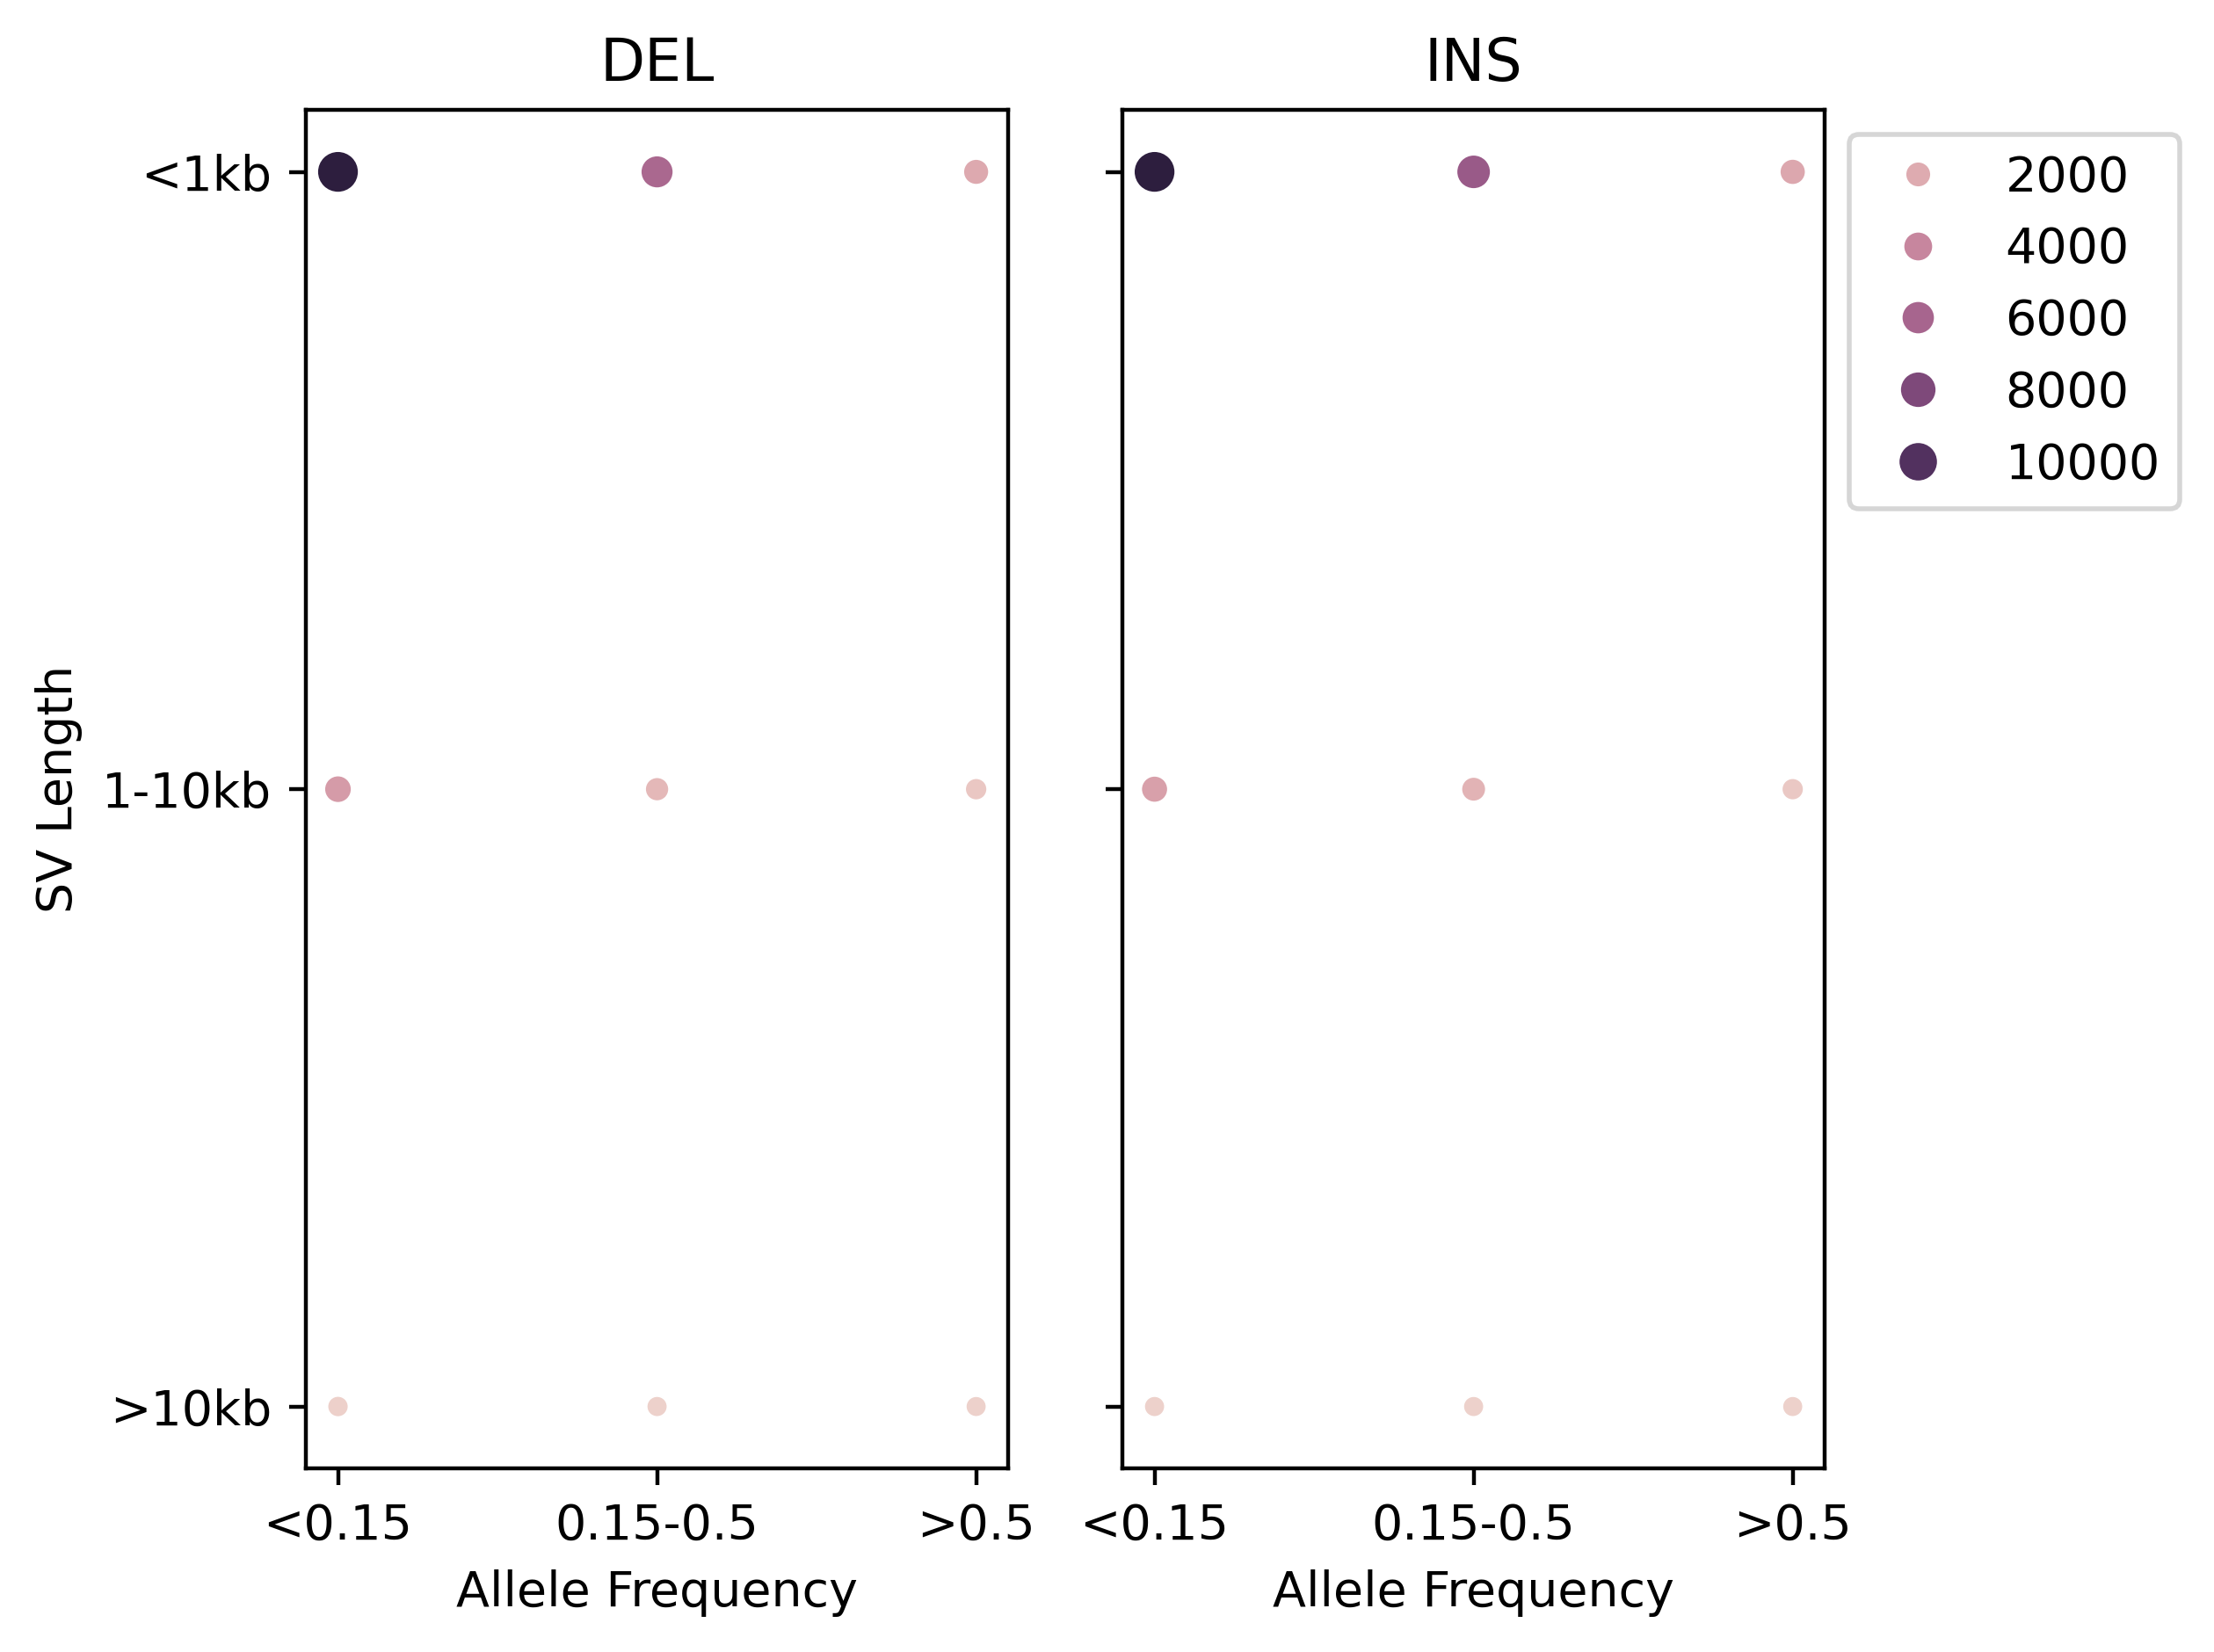

In [8]:
plot_dict = {'Allele Frequency':[],
             'SV Length':[],
             'Count':[],
             'sv_type':[]}
for allele_freq in bubble_plot_df['allele_freq_bins'].unique():
    for sv_len in bubble_plot_df['SV_length'].unique():
        ins_count = bubble_plot_df[(bubble_plot_df['allele_freq_bins'] == allele_freq) & (bubble_plot_df['SV_length'] == sv_len) & (bubble_plot_df['sv_type'] == 'INS')].shape[0]
        plot_dict['Allele Frequency'].append(allele_freq)
        plot_dict['SV Length'].append(sv_len)
        plot_dict['Count'].append(ins_count)
        plot_dict['sv_type'].append('INS')

        del_count = bubble_plot_df[(bubble_plot_df['allele_freq_bins'] == allele_freq) & (bubble_plot_df['SV_length'] == sv_len) & (bubble_plot_df['sv_type'] == 'DEL')].shape[0]
        plot_dict['Allele Frequency'].append(allele_freq)
        plot_dict['SV Length'].append(sv_len)
        plot_dict['Count'].append(del_count)
        plot_dict['sv_type'].append('DEL')

plot_df = pd.DataFrame.from_dict(plot_dict)
plot_df = plot_df[plot_df['Count'] > 0]
plot_df = plot_df.sort_values(by=['SV Length'], ascending=[False])

allele_freq_order = ['<0.15', '0.15-0.5', '>0.5']
sv_len_order = ['<1kb', '1-10kb', '>10kb']

plot_df['Allele Frequency'] = pd.Categorical(plot_df['Allele Frequency'], categories=allele_freq_order, ordered=True)
plot_df['SV Length'] = pd.Categorical(plot_df['SV Length'], categories=sv_len_order, ordered=True)



# sns.catplot(data=plot_df,
#             x='Allele Frequency',
#             y='SV Length',
#             col='sv_type',
#             size='Count',
#             kind='strip')
fig, ax = plt.subplots(dpi=400,
             nrows=1, ncols=2,
             sharey=True)

sns.scatterplot(data=plot_df[plot_df['sv_type'] == 'DEL'],
                x='Allele Frequency',
                y='SV Length',
                size='Count',
                hue='Count',
                ax=ax[0])
ax[0].set_title('DEL')
ax[0].set_xlabel('Allele Frequency')
ax[0].set_ylabel('SV Length')

sns.scatterplot(data=plot_df[plot_df['sv_type'] == 'INS'],
                x='Allele Frequency',
                y='SV Length',
                size='Count',
                hue='Count',
                ax=ax[1])
ax[1].set_title('INS')
ax[1].set_xlabel('Allele Frequency')
ax[1].set_ylabel('SV Length')
ax[0].legend().remove()

# Move the legend to an empty part of the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


In [7]:
svs_to_keep = sv_df.groupby(['sv_id']).agg('count')
svs_to_keep = svs_to_keep[svs_to_keep['sample'] >= 2].index.tolist()

# 


In [8]:
# sv_df
x = sv_df[sv_df['sv_id'].isin(svs_to_keep)]
x = sv_df.groupby(['sample','sv_type']).agg({'sv_length':'sum'}).reset_index()
# x = x.sort_values(by=['sample', 'sv_length'], ascending=False)
x['sv_type'].unique()

array(['DEL', 'DUP', 'INS', 'INV'], dtype=object)

In [12]:
y = x[x['sv_type'].isin(['DEL','INS',
                         'DUP', 'INV'])]
plot_dict = {}
all_plot_dict = {}

for sample in y['sample'].unique():
    ins_len = y[(y['sample'] == sample) & (y['sv_type'] == 'INS')]['sv_length'].sum()
    del_len = y[(y['sample'] == sample) & (y['sv_type'] == 'DEL')]['sv_length'].sum()
    dup_len = y[(y['sample'] == sample) & (y['sv_type'] == 'DUP')]['sv_length'].sum()
    inv_len = y[(y['sample'] == sample) & (y['sv_type'] == 'INV')]['sv_length'].sum()
    all_len = ins_len + del_len + dup_len + inv_len
    plot_dict[sample] = {'INS':ins_len, 'DEL':del_len,
                         'DUP':dup_len, 'INV':inv_len}
    all_plot_dict[sample] = all_len
plot_df = pd.DataFrame.from_dict(plot_dict).T
plot_df = plot_df.reset_index()
plot_df.columns = ['sample','INS','DEL', 'DUP', 'INV',]
plot_df = plot_df.melt(id_vars='sample').rename(columns={'variable':'SV_type','value':'Length'})
all_plot_df = pd.DataFrame.from_dict(all_plot_dict, orient='index').reset_index()
all_plot_df.columns = ['sample','Length']
plot_df
all_plot_df

,sample,Length
0,sample01,22567295
1,sample02,18107608
2,sample03,22065509
3,sample04,24294351
4,sample05,23447798
5,sample06,23486318
6,sample07,21441749
7,sample08,23998106
8,sample09,24276180
9,sample10,19077557


Text(0.5, 1.0, 'Length of INV SVs')

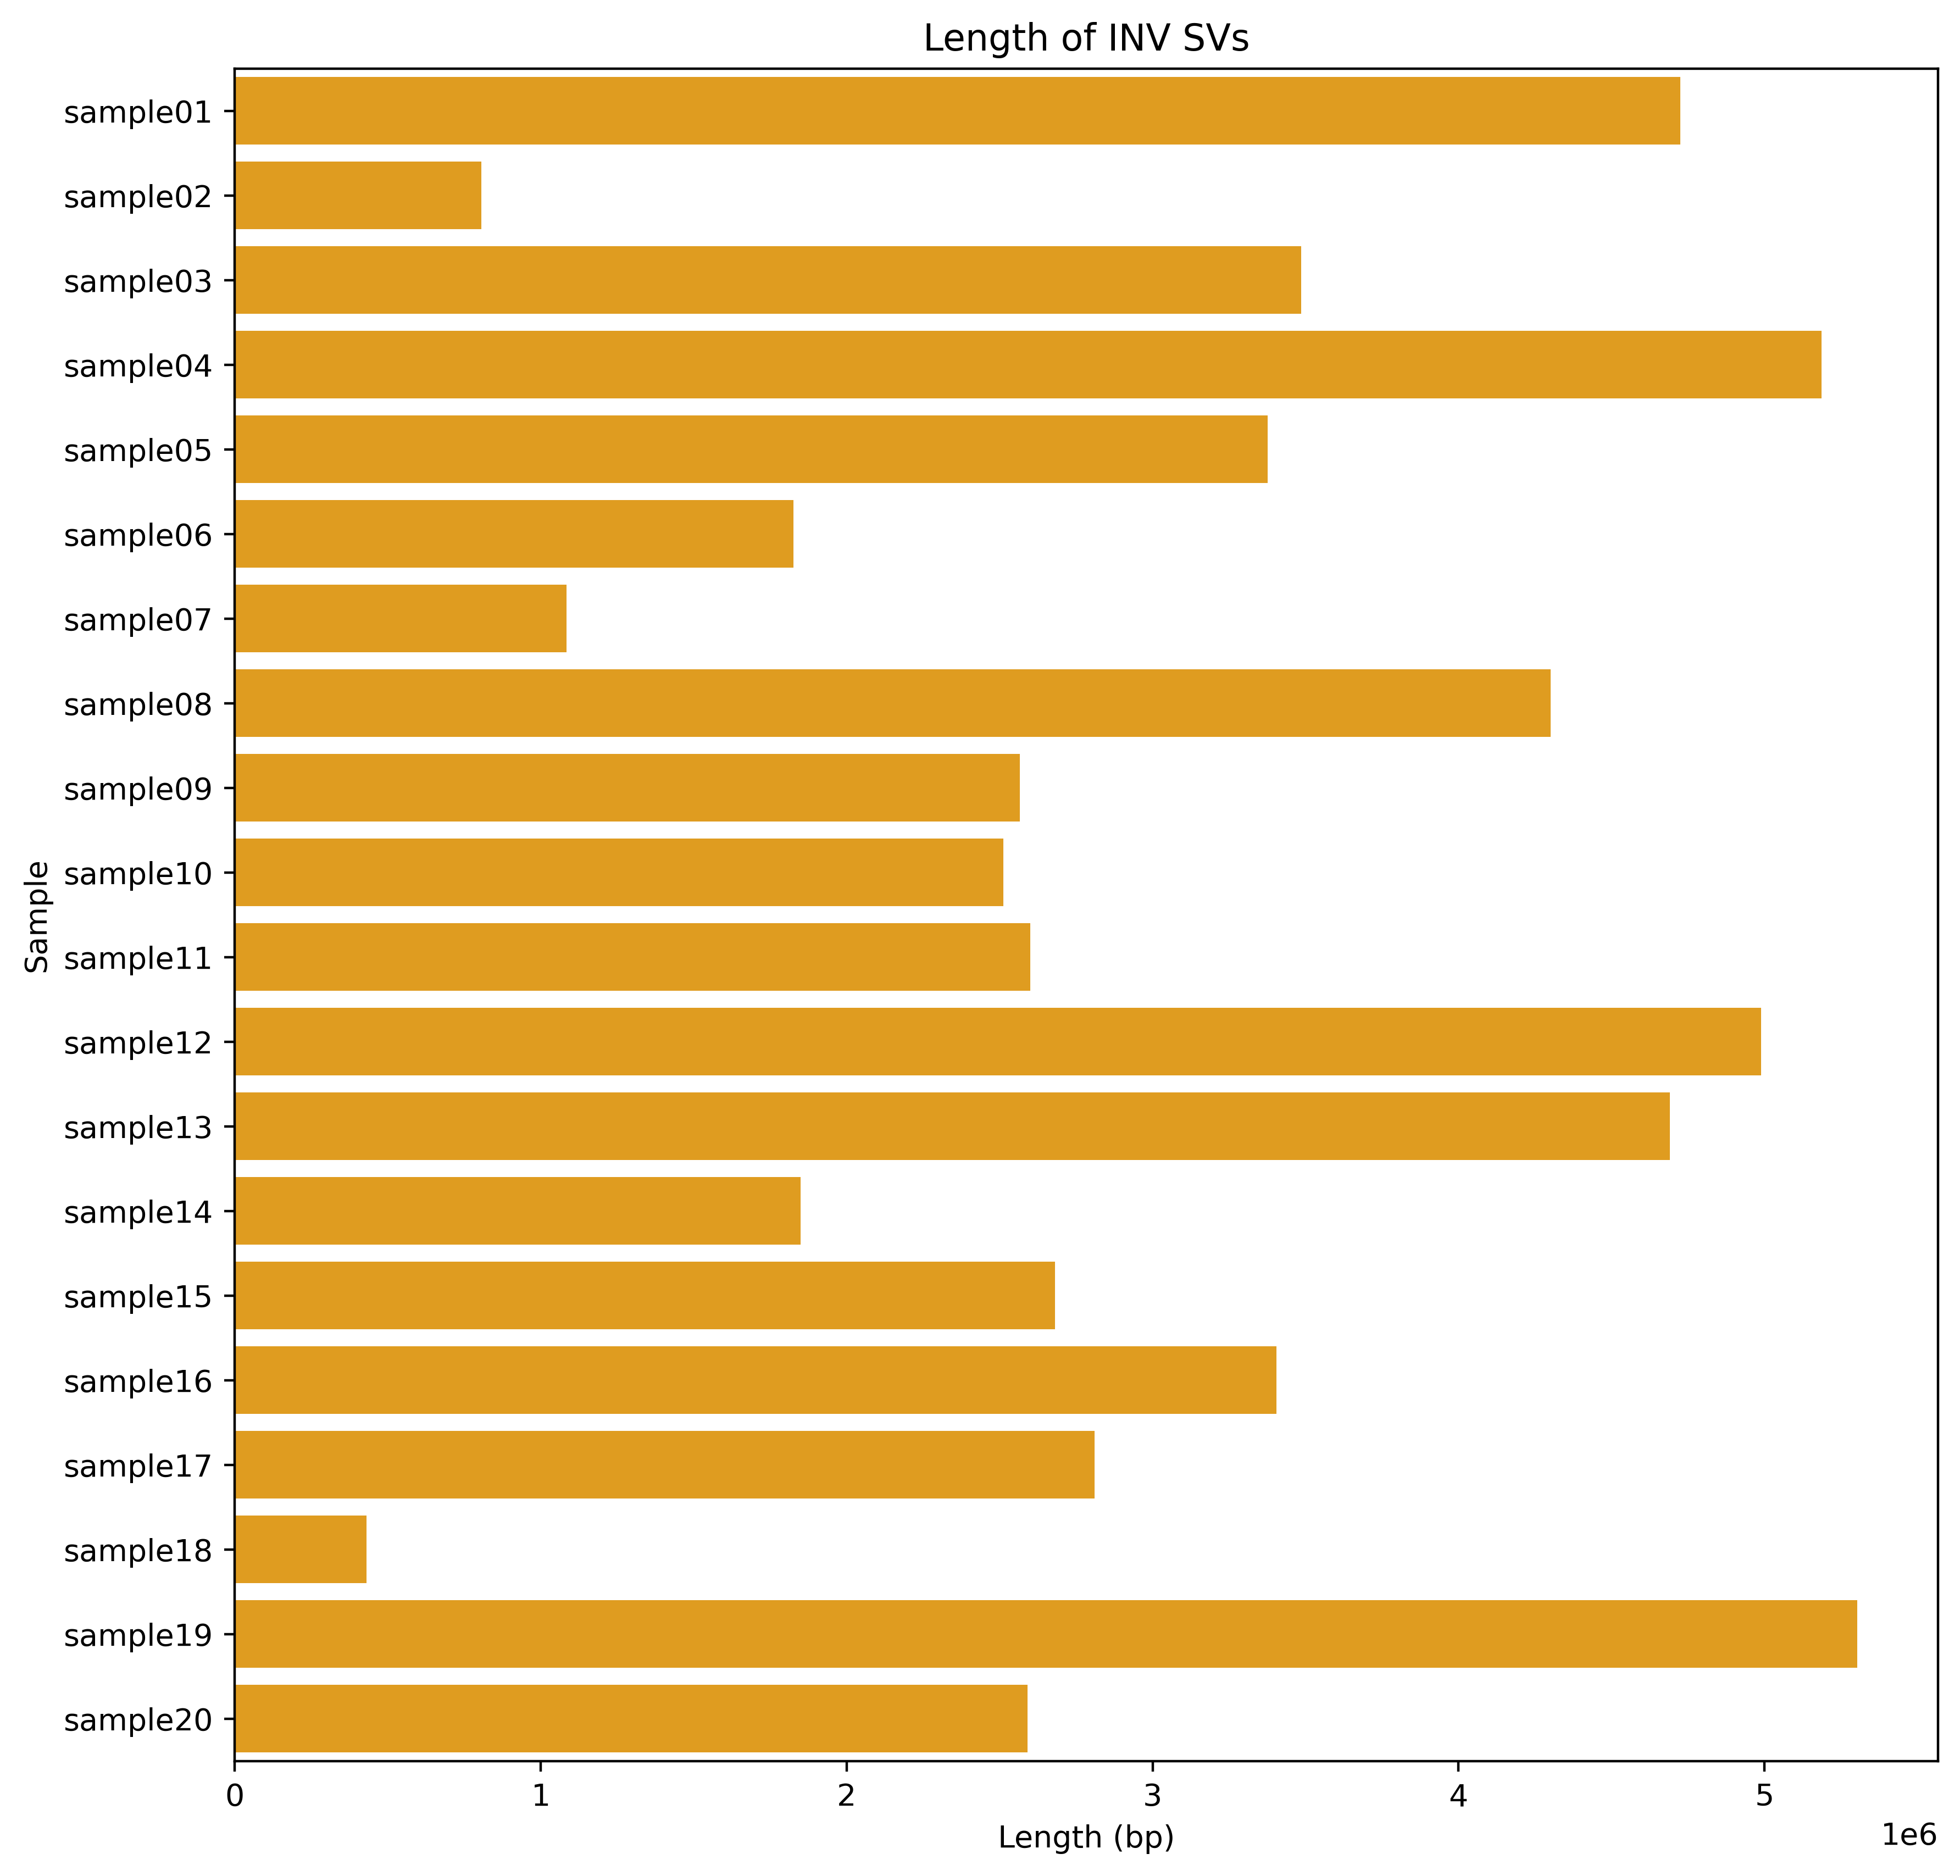

In [ ]:
# SV_TYPE = 'INV'
# plt.figure(figsize=(10,10), dpi=400)
# # sns.barplot(data=plot_df, y='sample',
# #             x='Length', hue='SV_type',
# #             col_wrap = 2, col='SV_type', kind='bar',
# #             hue_order=['DUP','INV','INS','DEL'])

# sns.barplot(data=plot_df[plot_df['SV_type'] == SV_TYPE], y = 'sample',
#             x='Length', orient='h',
#             color='orange')
# plt.xlabel('Length (bp)')
# plt.ylabel('Sample')
# plt.title(f'Length of {SV_TYPE} SVs')


/var/folders/vl/n44v99hn7v96skr346cz_cl80000gn/T/ipykernel_22132/4091826476.py:12: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 1e7)


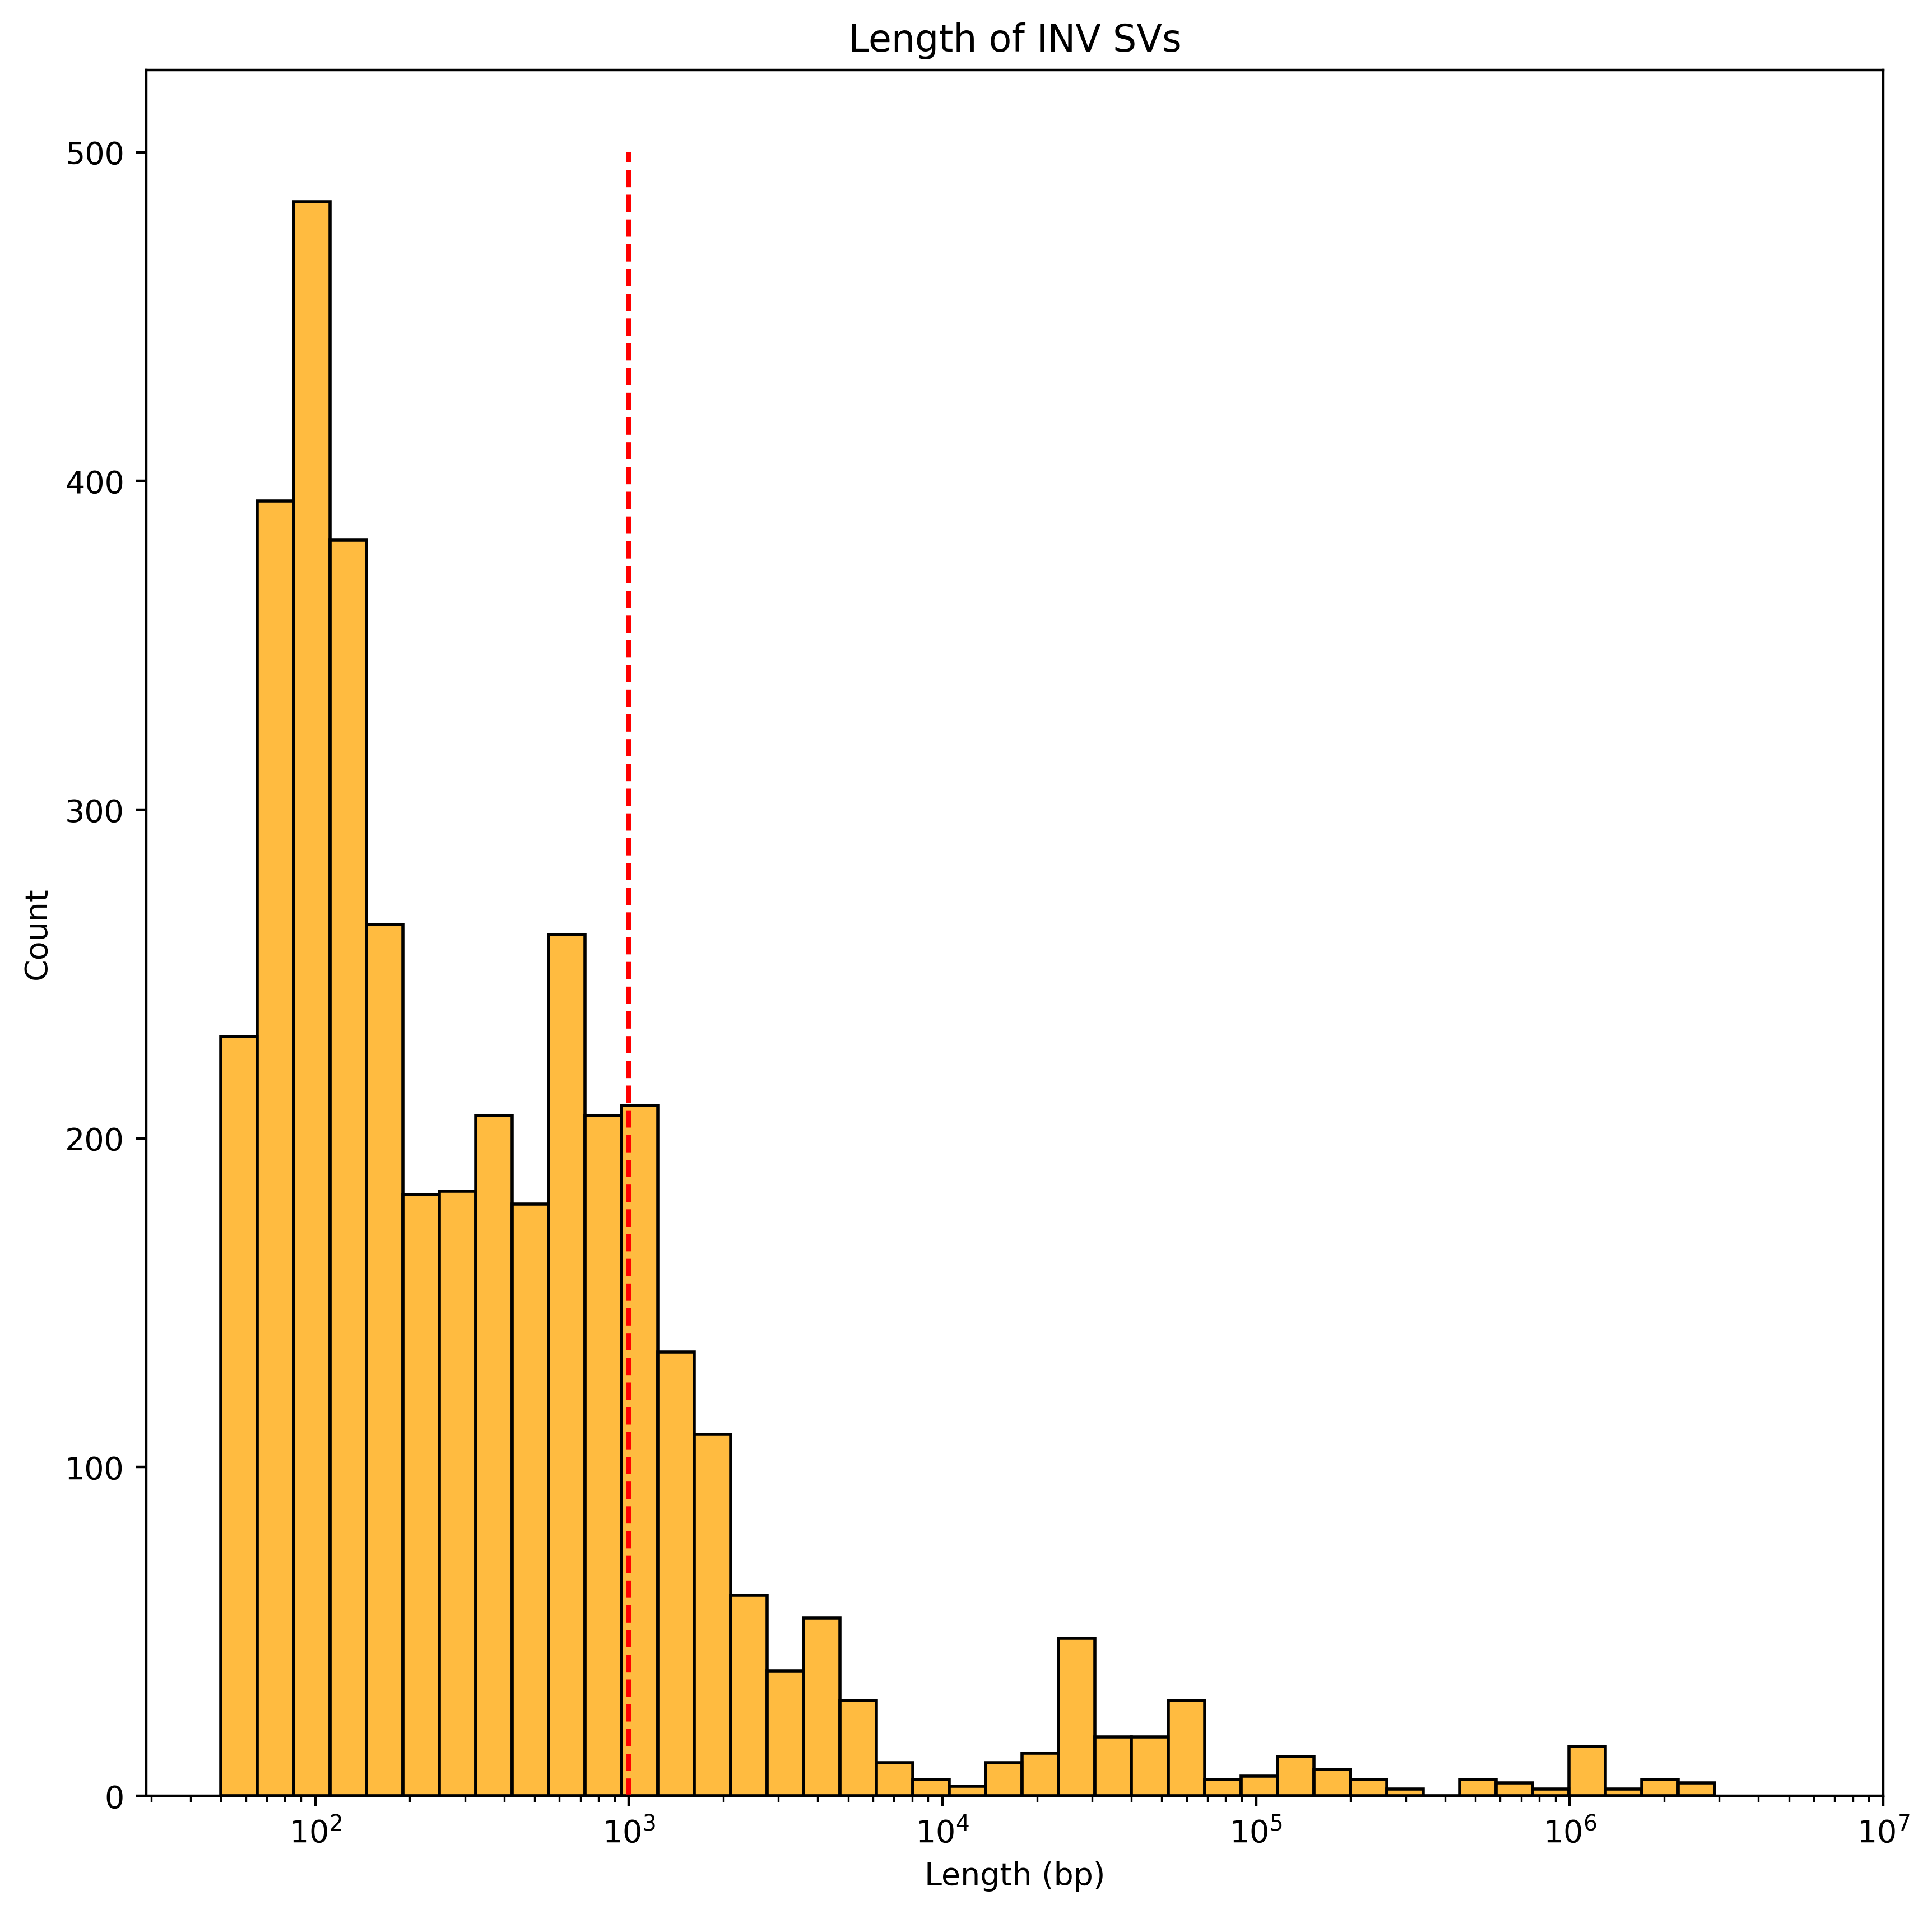

In [32]:
SV_TYPE = 'INV'
plt.figure(figsize=(10,10), dpi=400)
# sns.barplot(data=plot_df, y='sample',
#             x='Length', hue='SV_type',
#             col_wrap = 2, col='SV_type', kind='bar',
#             hue_order=['DUP','INV','INS','DEL'])

sns.histplot(data=sv_df[sv_df['sv_type'] == SV_TYPE],
            x='sv_length',log_scale=True,
            color='orange')
plt.xlabel('Length (bp)')
plt.xlim(0, 1e7)
plt.title(f'Length of {SV_TYPE} SVs')
plt.vlines(x=1e3, ymin=0, ymax=500, color='red', linestyle='--')

In [62]:
sv_df[sv_df['sv_type'] == SV_TYPE].groupby('sample').agg({'sv_type':'count'}).mean()

sv_type    192.3
dtype: float64

In [63]:
plot_df[plot_df['SV_type'] == SV_TYPE]['Length'].mean()

np.float64(3061098.15)

sv_type    10582.75
dtype: float64

In [28]:
plot_df[plot_df['SV_type'] == 'INS']

,sample,SV_type,Length
0,sample01,INS,6485628
1,sample02,INS,6426372
2,sample03,INS,6168161
3,sample04,INS,7507380
4,sample05,INS,7236057
5,sample06,INS,7590185
6,sample07,INS,8198704
7,sample08,INS,8101687
8,sample09,INS,7859077
9,sample10,INS,5854453


In [114]:
# Get stats on human SVs
human_sv = VariantFile('/Users/callummacphillamy/Downloads/gnomad.v4.1.sv.sites.vcf.gz')

svs = {'INS':[],
       'DEL':[],
       'DUP':[],
       'INV':[]}

total_svs = 0

for record in tqdm(human_sv.fetch()):
    if 'PASS' not in record.filter.keys():
        continue
    
    try:
        if record.info['N_BI_GENOS_nfe'] < 10000:
            continue
    except KeyError:
        continue

    total_svs += 1

    sv_type = record.info['SVTYPE']
    sv_len = record.info['SVLEN']

    if sv_type not in ['DEL', 'DUP', 'INV', 'INS']:
        continue
    svs[sv_type].append(sv_len)

[E::idx_find_and_load] Could not retrieve index file for '/Users/callummacphillamy/Downloads/gnomad.v4.1.sv.sites.vcf.gz'
2154486it [02:16, 15785.71it/s]


In [115]:
for k, v in svs.items():
    print(k, np.median(v))

INS 280.0
DEL 703.0
DUP 338.0
INV 7095.0


In [86]:
x = sv_df[sv_df['sv_id'].isin(svs_to_keep)]
x = sv_df.groupby(['sv_type']).agg({'sv_length':'median'}).reset_index()
x
# for sample in y['sample'].unique():
#     ins_len = y[(y['sample'] == sample) & (y['sv_type'] == 'INS')]['sv_length'].median()
#     del_len = y[(y['sample'] == sample) & (y['sv_type'] == 'DEL')]['sv_length'].median()
#     dup_len = y[(y['sample'] == sample) & (y['sv_type'] == 'DUP')]['sv_length'].median()
#     inv_len = y[(y['sample'] == sample) & (y['sv_type'] == 'INV')]['sv_length'].median()
#     all_len = ins_len + del_len + dup_len + inv_len
#     plot_dict[sample] = {'INS':ins_len, 'DEL':del_len,
#                          'DUP':dup_len, 'INV':inv_len}
#     all_plot_dict[sample] = all_len
# plot_df = pd.DataFrame.from_dict(plot_dict).T
# plot_df = plot_df.reset_index()
# plot_df

,sv_type,sv_length
0,DEL,143.0
1,DUP,4522.0
2,INS,203.0
3,INV,241.5


In [ ]:
all_plot_df

,sample,Length,Variant
0,sample01,22567295,SV
1,sample02,18107608,SV
2,sample03,22065509,SV
3,sample04,24294351,SV
4,sample05,23447798,SV
5,sample06,23486318,SV
6,sample07,21441749,SV
7,sample08,23998106,SV
8,sample09,24276180,SV
9,sample10,19077557,SV


In [14]:
for sample in plot_df['sample'].unique():
    total_affected_bases = plot_df[plot_df['sample'] == sample]['Length'].sum()
    print(f'{sample} has {total_affected_bases} bases affected by large INS/DELs')

sample01 has 22567295 bases affected by large INS/DELs
sample02 has 18107608 bases affected by large INS/DELs
sample03 has 22065509 bases affected by large INS/DELs
sample04 has 24294351 bases affected by large INS/DELs
sample05 has 23447798 bases affected by large INS/DELs
sample06 has 23486318 bases affected by large INS/DELs
sample07 has 21441749 bases affected by large INS/DELs
sample08 has 23998106 bases affected by large INS/DELs
sample09 has 24276180 bases affected by large INS/DELs
sample10 has 19077557 bases affected by large INS/DELs
sample11 has 23029859 bases affected by large INS/DELs
sample12 has 20928576 bases affected by large INS/DELs
sample13 has 23759349 bases affected by large INS/DELs
sample14 has 26152924 bases affected by large INS/DELs
sample15 has 21521918 bases affected by large INS/DELs
sample16 has 25563167 bases affected by large INS/DELs
sample17 has 23848702 bases affected by large INS/DELs
sample18 has 21525032 bases affected by large INS/DELs
sample19 h

In [15]:
all_plot_df

,sample,Length,Variant
0,sample01,22567295,SV
1,sample02,18107608,SV
2,sample03,22065509,SV
3,sample04,24294351,SV
4,sample05,23447798,SV
5,sample06,23486318,SV
6,sample07,21441749,SV
7,sample08,23998106,SV
8,sample09,24276180,SV
9,sample10,19077557,SV


In [16]:
# Get the number of SNPs
VCFS = glob.glob('/Users/callummacphillamy/Projects/tuwa_manuscript/TuWa_manuscript/SNP_analyses/genotypes/SNPs/*.vcf.gz')

bases_affected_by_snps = {}

for vcf in tqdm(VCFS):
    sample_name = os.path.basename(vcf).split('.')[0]
    if bases_affected_by_snps.get(sample_name) is None:
        bases_affected_by_snps[sample_name] = 0
    v_file = VariantFile(vcf)
    for record in v_file.fetch():
        #print(record)
        if 'PASS' not in record.filter.keys():
            continue
        if record.qual < 20:
            continue
        alleles = record.alleles
        ref = record.ref
        
        # Ignore any variants where one of the alleles is longer than 1 bp.
        for allele in alleles:
            if len(allele) > 1:
                continue

        gt = record.samples[sample_name]['GT']
        if gt in [(None,None), (0,0)]:
            continue

        allele_1 = len(alleles[gt[0]])
        allele_2 = len(alleles[gt[1]])

        if allele_1 >= allele_2:
            bases_affected_by_snps[sample_name] += allele_1
        else:
            bases_affected_by_snps[sample_name] += allele_2


100%|██████████| 20/20 [09:35<00:00, 28.79s/it]


([<matplotlib.axis.XTick at 0x1eda69e40>,
 [Text(0.0, 0, '0'),
  Text(5000000.0, 0, '5Mb'),
  Text(10000000.0, 0, '10Mb'),
  Text(15000000.0, 0, '15Mb'),
  Text(20000000.0, 0, '20Mb'),
  Text(25000000.0, 0, '25Mb'),
  Text(30000000.0, 0, '30Mb')])

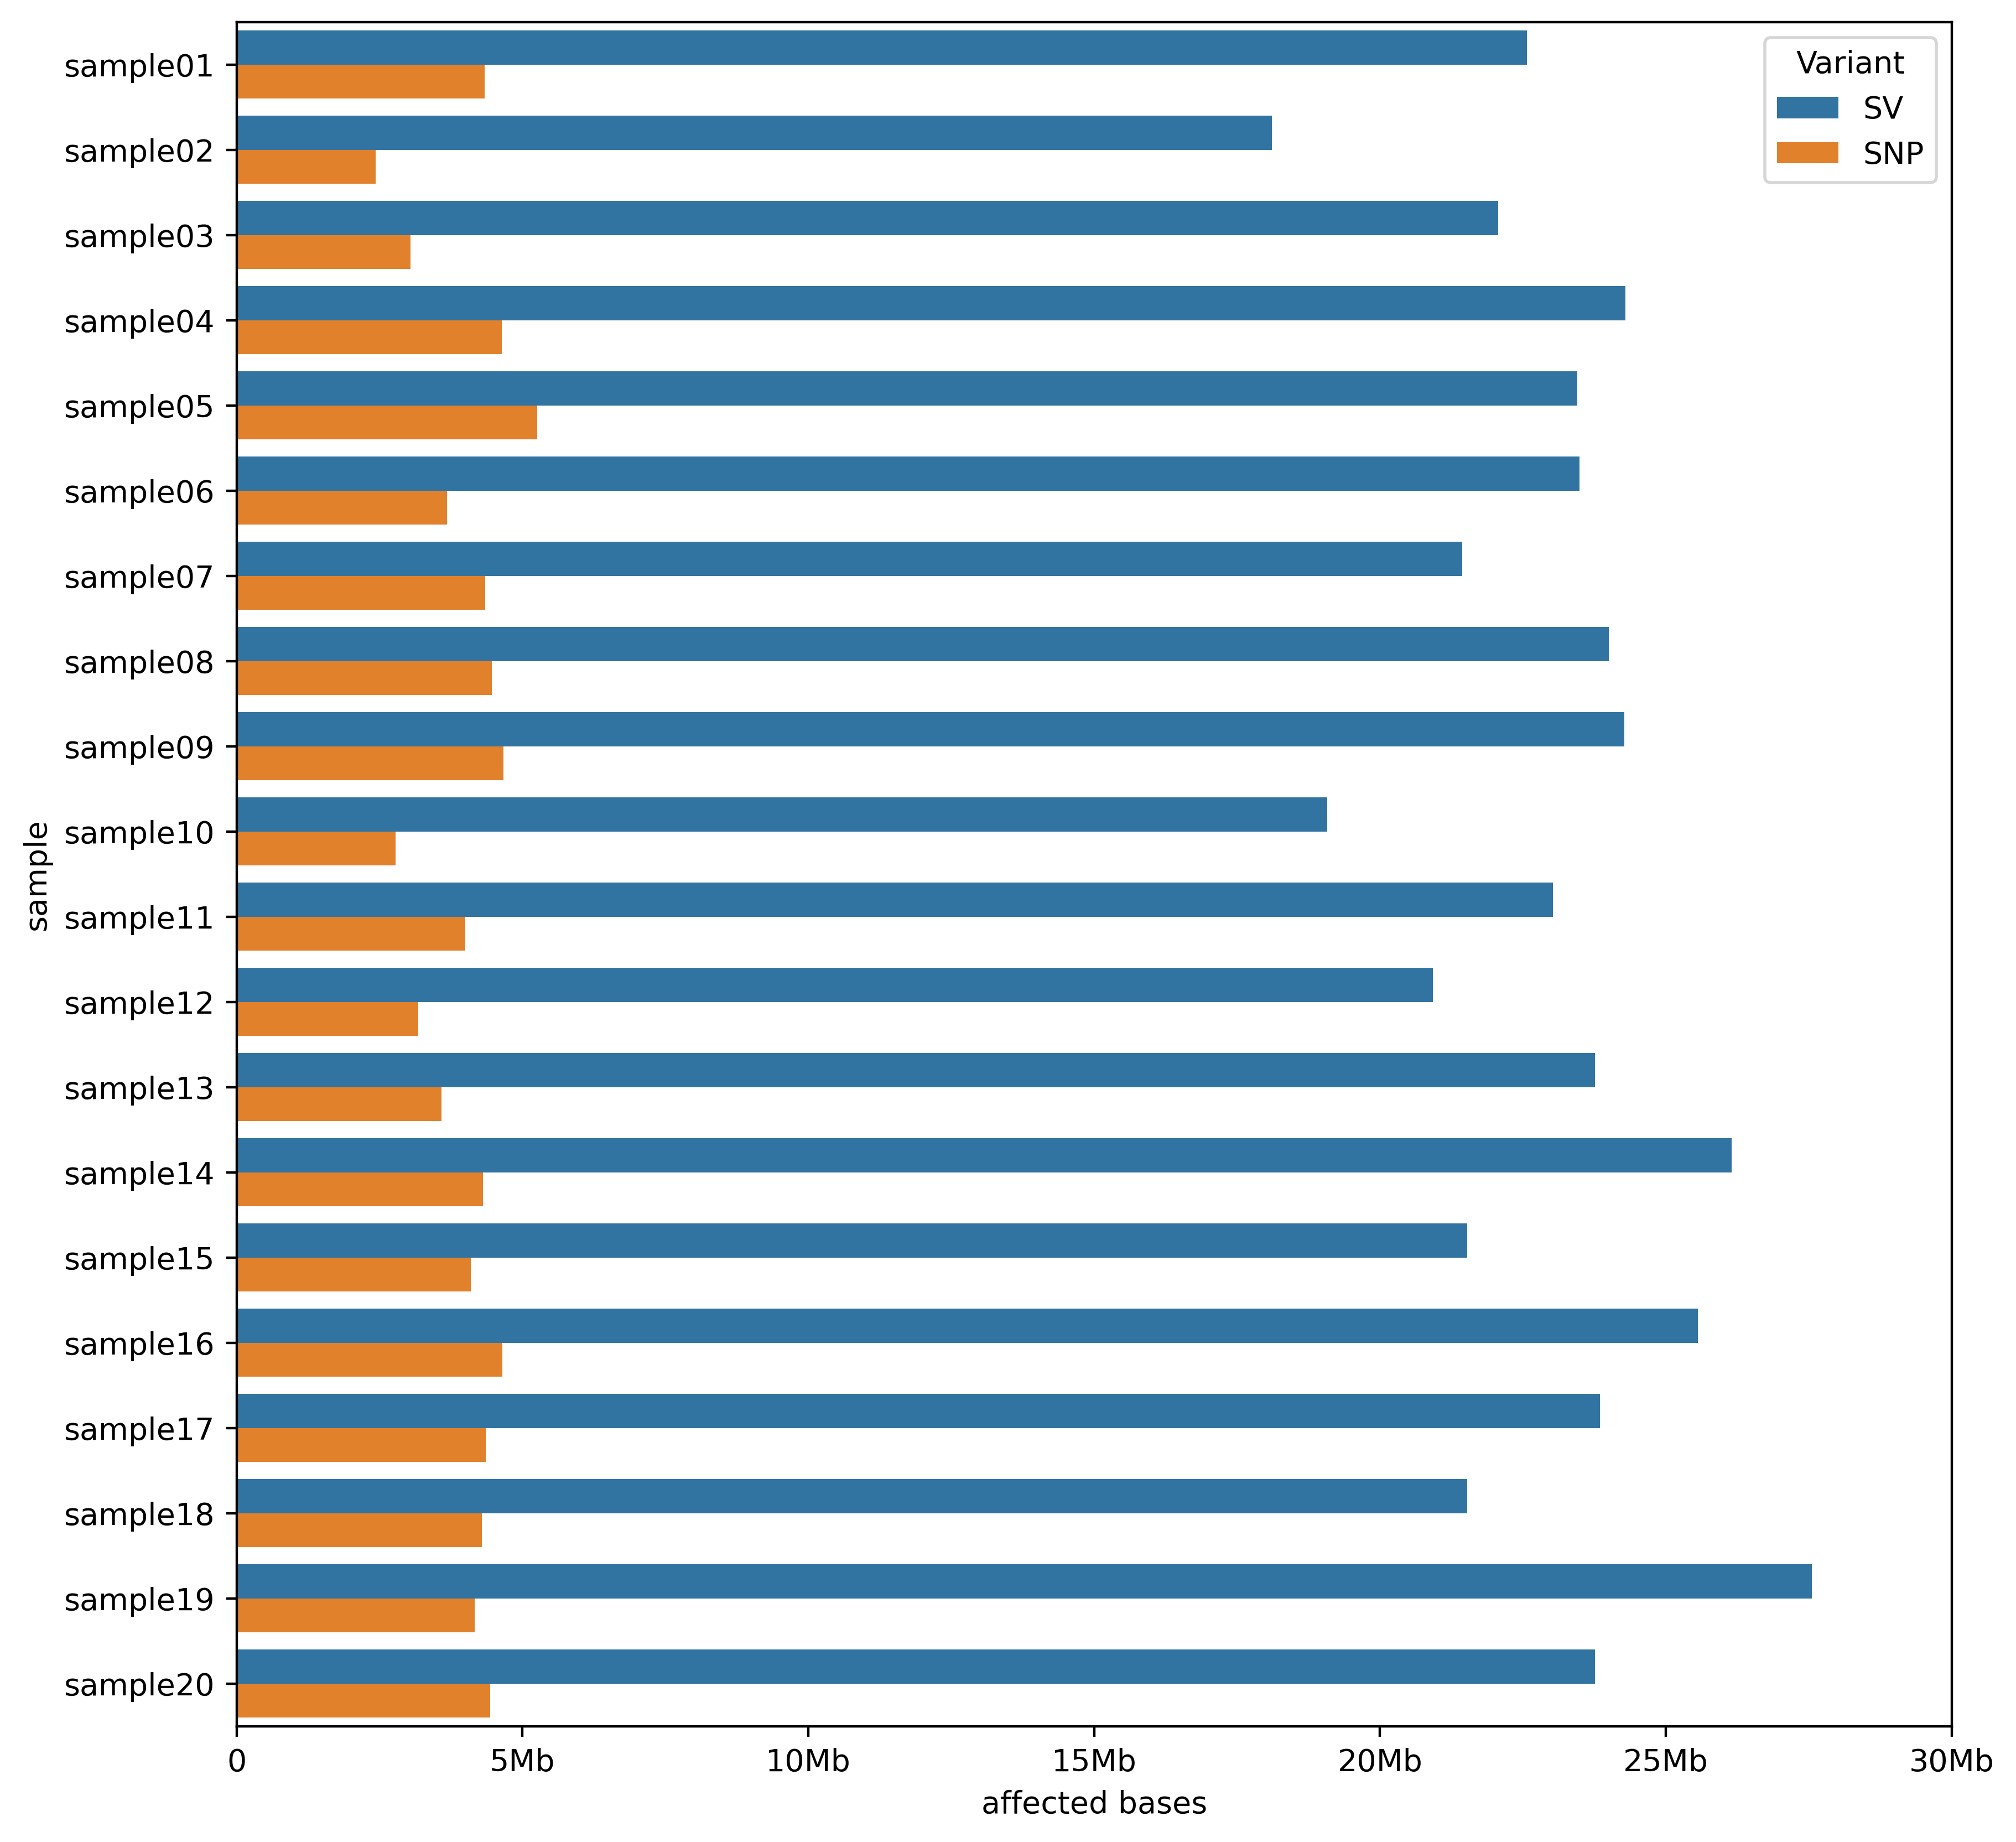

In [29]:
plt.figure(figsize=(10,10), dpi=400)
snps = pd.DataFrame.from_dict(bases_affected_by_snps, orient='index', columns=['affected bases']).reset_index()
snps.columns = ['sample','affected bases']

snps['Variant'] = 'SNP'
all_plot_df = all_plot_df.rename(columns={'Length':'affected bases'})
snp_vs_sv_df = pd.concat([all_plot_df, snps])
snp_vs_sv_df
sns.barplot(data=snp_vs_sv_df, y='sample', x='affected bases', hue='Variant')

# # Set the X axis to a more human readable scale. I.e., 1000000 instead of 1e6
plt.xlim(0, 1e7)
plt.xticks(ticks=[0, 0.5e7, 1e7, 1.5e7, 2e7, 2.5e7, 3e7],
           labels=['0', '5Mb', '10Mb', '15Mb', '20Mb', '25Mb', '30Mb'])



In [25]:
.5e7

5000000.0

In [93]:
sv_df['length_bins'] = pd.cut(sv_df['sv_length'], bins=[0, 1000, 10000, 100000, 1000000, 10000000, 100000000], labels=['0-1kb','1-10kb','10-100kb','100kb-1Mb','1Mb-10Mb','10Mb-100Mb'])

<Axes: xlabel='length_bins', ylabel='Count'>

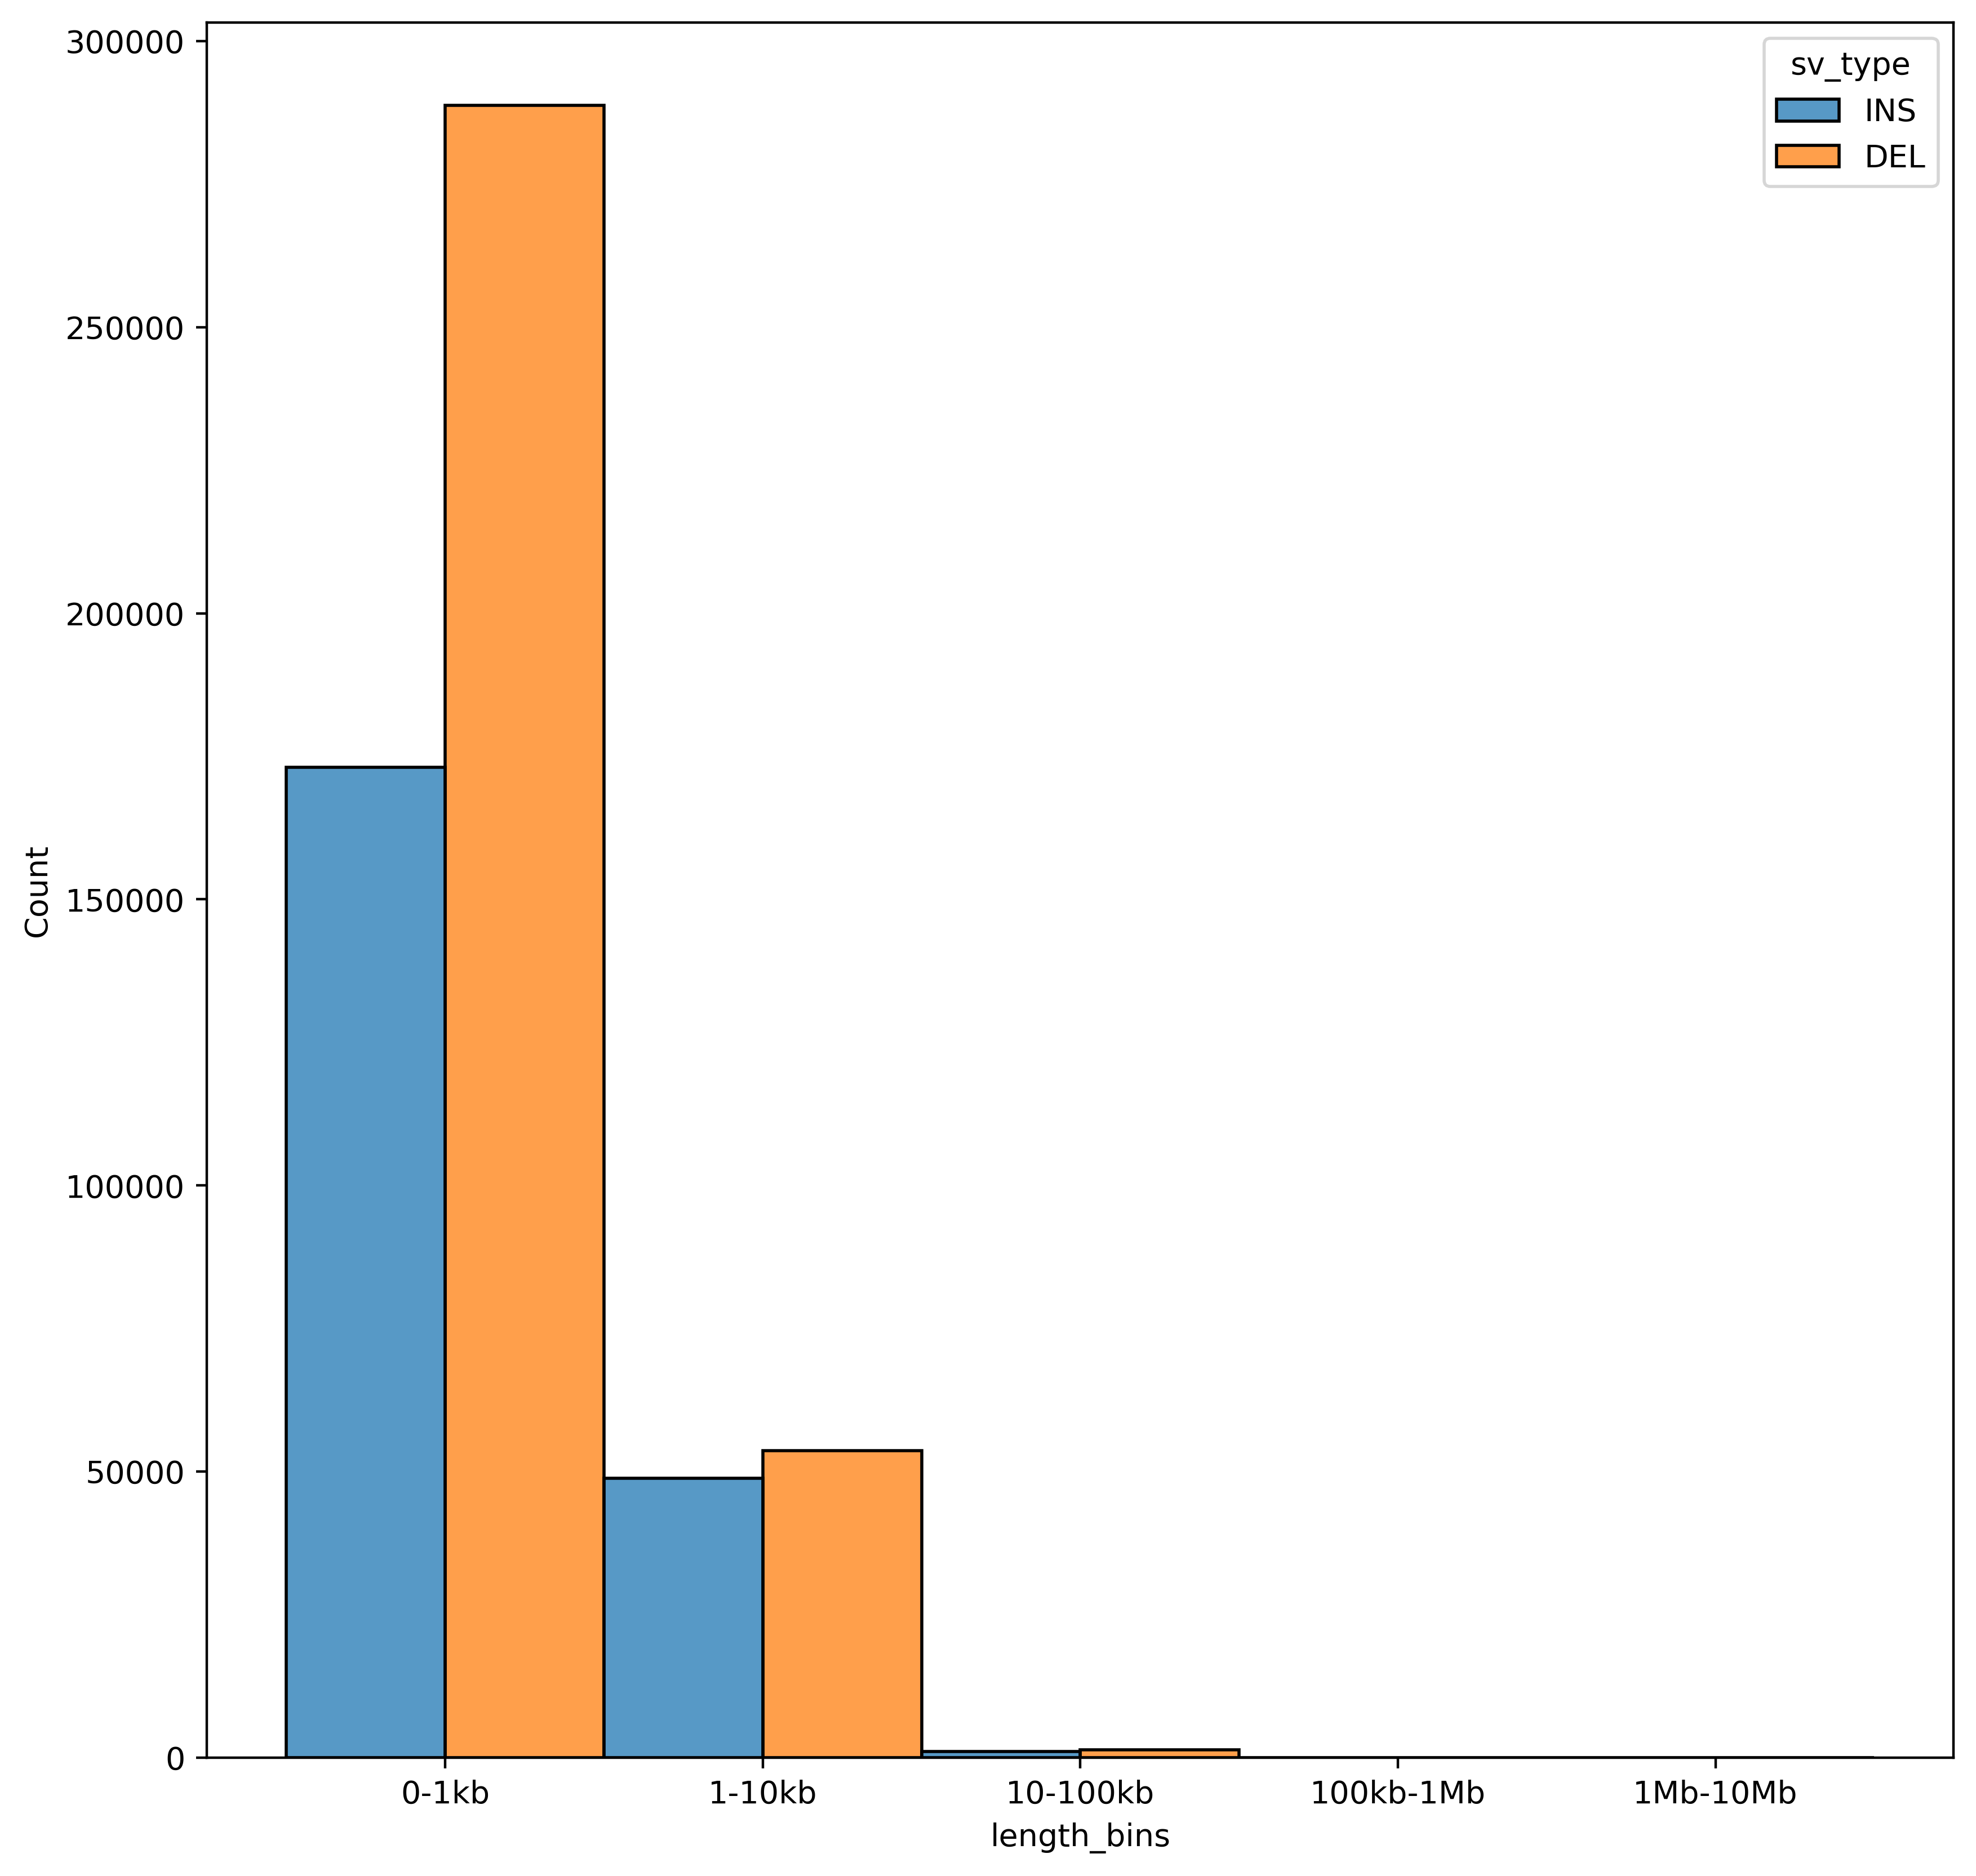

In [94]:
plt.figure(figsize=(10,10), dpi=400)
sns.histplot(data=sv_df[sv_df['sv_type'].isin(['INS','DEL'])],
             x='length_bins', hue='sv_type', multiple='dodge')

In [95]:
53166 / 5838967

0.009105377714928

In [40]:
# Merge SVs
samples = ['sample11','sample05','sample04','sample10','sample06','sample12',
           'sample13','sample07','sample03','sample17','sample16','sample02',
           'sample14','sample01','sample15','sample18','sample19','sample09',
           'sample08','sample20']
SNIFFLES_MERGE ='../../../tuwa_manuscript/TuWa_manuscript/RESULTS/mapped_to_wagyu/SVs/sniffles/snfs/wagyu.cohort.vcf'

sniffles_merge = VariantFile(SNIFFLES_MERGE)

atleast_2 = []

for record in sniffles_merge.fetch():
    #print(record)
    #print(record.info['SUPP_VEC'])
    if record.info['SUPP_VEC'].count('1') >= 2:
        atleast_2.append(record)
print(len(atleast_2))

48317


In [42]:
print(atleast_2[0])

1	1042373	Sniffles2.DEL.1M4	N	<DEL>	30	PASS	IMPRECISE;SVTYPE=DEL;SVLEN=-1402;END=1043774;SUPPORT=3;COVERAGE=4,4,4,4,4;STRAND=+-;AC=2;STDEV_LEN=2.121;STDEV_POS=88.388;SUPP_VEC=00000000010000100000	GT:GQ:DR:DV:ID	./.:0:0:0:NULL	./.:0:2:0:NULL	./.:0:1:0:NULL	./.:0:0:0:NULL	./.:0:0:0:NULL	./.:0:1:0:NULL	./.:0:2:0:NULL	./.:0:2:0:NULL	./.:0:0:0:NULL	0/1:11:2:3:Sniffles2.DEL.77BS0	./.:0:1:0:NULL	./.:0:0:0:NULL	./.:0:0:0:NULL	./.:0:0:0:NULL	0/1:1:1:3:Sniffles2.DEL.731S0	./.:0:0:0:NULL	./.:0:3:0:NULL	./.:0:0:0:NULL	./.:0:2:0:NULL	./.:0:0:0:NULL

